In [1]:
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

Segmentation Models: using `keras` framework.


In [2]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import load_model
import h5py
from tensorflow.keras import __version__ as keras_version
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Activation, Lambda, Cropping2D, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import GlobalMaxPooling2D

In [306]:
import os
import csv
import cv2
import sys
import glob
import collections
import pandas as pd
import itertools
import numpy as np
import seaborn as sns
from tqdm import tqdm

from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn import model_selection

import xml.etree.ElementTree as ET

In [65]:
# sys.path.append("../lib/cv")
# import GradientThresholds as GradThresh
# from GradientThresholds import GradientThresholds

# import importlib
# importlib.reload(GradThresh)

In [4]:
class GradientThresholds:
    def __init__(self):
        self.img_m = None

    def apply_sobel_thresh(self, img, orient="x", ksize=(3,3), thresh=(0,255)):
        """
            Calculate directional gradient and identify pixels where the gradient
            falls within a particular threshold range for an image. Pass in image,
            choose orient to be x or y gradient, pick threshold min and max range
            to select for binary_output. The binary_output array is 1 where gradients
            are in threshold range, 0 everywhere else.
        """
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        gray = cv2.GaussianBlur(gray, ksize, 0)

        if orient == "x":
            # apply sobel in "x" direction
            sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        elif orient == "y":
            sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        # Take abs value of derivative aka gradient
        abs_sobel = np.absolute(sobel)

        # scale result to 8-bit range (0-255)
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

        # apply lower and upper thresholds to mask scaled gradient
        binary_image = np.zeros_like(scaled_sobel)

        # apply 1's when scaled gradient is within threshold
        binary_image[(scaled_sobel >= thresh[0]) &
                     (scaled_sobel <= thresh[1])] = 1

        return binary_image

    # TODO: Create Gradient Magnitude Thresholding method
    def apply_grad_mag_thresh(self, img, sobel_kernel=3, mag_thresh=(0, 255)):
        """
            Calculate gradient magnitude
        """
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # take gradient in x and y separately
        sobelx  = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
        sobely  = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
        # calculate gradient magnitude in x and y direction
        grad_mag = np.sqrt( (sobelx**2) + (sobely**2) )
        # scale to 8-bit and convert to type=np.uint8
        scale_factor = np.max(grad_mag)/255
        scaled_grad_mag = (grad_mag/scale_factor).astype(np.uint8)
        # create a binary mask where mag thresholds are met
        binary_image = np.zeros_like(scaled_grad_mag)
        binary_image[(scaled_grad_mag >= mag_thresh[0]) &
                     (scaled_grad_mag <= mag_thresh[1])] = 1
        return binary_image
    
    # TODO: Create Gradient Direction Thresholding method
    def apply_grad_dir_thresh(self, img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # take gradient in x and y separately
        sobelx  = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
        sobely  = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
        # abs value of x and y gradients
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)
        # calculate the gradient direction
        dir_grad = np.arctan2(abs_sobely, abs_sobelx)
        
        # create binary image where direction thresholds are met
        binary_image = np.zeros_like(dir_grad)
        binary_image[(dir_grad >= dir_thresh[0]) & (dir_grad <= dir_thresh[1])] = 1
        return binary_image
    
    # TODO: Create Combined Thresholding method
    def apply_combined_thresh(self, combination_code, grad_x = None, grad_y = None, grad_mag = None, grad_dir = None):
        combined = np.zeros_like(grad_x)
        if combination_code == 0:
            combined[ (grad_x == 1) & (grad_mag == 1) ] = 1
        elif combination_code == 1:
            combined[ (grad_x == 1) & (grad_dir == 1) ] = 1
        elif combination_code == 2: 
            combined[ (grad_x == 1) & (grad_mag == 1) & (grad_dir == 1) ] = 1  
        elif combination_code == 3:
            combined[ (grad_x == 1) & (grad_y == 1) & 
                      (grad_mag == 1) & (grad_dir == 1) ] = 1             
        else:
            print("Error: Choose a supported code for combined gradient")

        # Return binary result from multiple thresholds
        return combined
    
    def save_img(self, dst_path, filename, dst_img):
        """
            Save gradient thresholded image using OpenCV
        """
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)

        plt.imsave(dst_path + filename, dst_img, cmap="gray")

    def visualize(self, src_title, orig_img, dst_title, binary_img):
        """
            Visualize gradient thresholded image
        """
        img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title(src_title, fontsize=50)
        ax2.imshow(binary_img, cmap="gray")
        ax2.set_title(dst_title, fontsize=50)
        plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.)


In [5]:
class ColorThresholds:
    # Apply Grayscale Thresholding
    def apply_gray_thresh(self, img, thresh = (0, 255)):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        binary_img = np.zeros_like(gray)
        binary_img[ (gray > thresh[0]) & (gray <= thresh[1]) ] = 1
        return binary_img
    
    # Thresholding individual RGB Color Channels
    def apply_r_thresh(self, img, thresh = (0, 255)):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        r_img = img[:,:,0]
        binary_img = np.zeros_like(r_img)
        binary_img[ (r_img >= thresh[0]) & (r_img <= thresh[1]) ] = 1
        return binary_img
    
    def apply_g_thresh(self, img, thresh = (0, 255)):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        g_img = img[:,:,1]
        binary_img = np.zeros_like(g_img)
        binary_img[ (g_img >= thresh[0]) & (g_img <= thresh[1]) ] = 1
        return binary_img        

    def apply_b_thresh(self, img, thresh = (0, 255)):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        b_img = img[:,:,2]
        binary_img = np.zeros_like(b_img)
        binary_img[ (b_img >= thresh[0]) & (b_img <= thresh[1]) ] = 1
        return binary_img  
    
    def apply_rgb_thresh(self, num_code, rgb_r = None, rgb_g = None, rgb_b = None):
        """
            Combine RGB Thresholding binary images based on the red, green and/or
            blue thresholds already applied, they set private variables that can be
            used in this method. Choose based on number code, which thresholds you'd
            combine:
            0: R Binary, G Binary
            1: R Binary, B binary
            2: G Binary, B Binary
            3: R Binary, G Binary, B Binary
        """
        combined = np.zeros_like(rgb_r)
        if num_code == 0:
            combined[ (rgb_r == 1) | (rgb_g == 1) ] = 1
        elif num_code == 1:
            combined[ (rgb_r == 1) & (rgb_b == 1) ] = 1
        elif num_code == 2: 
            combined[ (rgb_g == 1) & (rgb_b == 1) ] = 1  
        elif num_code == 3:
            combined[ ((rgb_r == 1) | (rgb_g == 1)) & (rgb_b == 1) ] = 1             
        else:
            print("Error: Choose a supported code for combined rgb")

        # Return binary result from multiple thresholds
        return combined
    
    # Thresholding individual HSL Color Channels
    def apply_h_thresh(self, img, thresh = (0, 255)):
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        h_img = hls[:,:,0]
        binary_img = np.zeros_like(h_img)
        binary_img[ (h_img >= thresh[0]) & (h_img <= thresh[1]) ] = 1
        return binary_img
    
    def apply_l_thresh(self, img, thresh = (0, 255)):
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        l_img = hls[:,:,1]
        binary_img = np.zeros_like(l_img)
        binary_img[ (l_img >= thresh[0]) & (l_img <= thresh[1]) ] = 1
        return binary_img
    
    def apply_s_thresh(self, img, thresh = (0, 255)):
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        s_img = hls[:,:,2]
        binary_img = np.zeros_like(s_img)
        binary_img[ (s_img >= thresh[0]) & (s_img <= thresh[1]) ] = 1
        return binary_img
    
    # Apply Combined HLS Thresholding
    def apply_hls_thresh(self, num_code, hls_h = None, hls_l = None, hls_s = None):
        """
            Combine HLS Thresholding binary images based on the hue, lightness
            and/or saturation thresholds already applied, they set private 
            variables that can be used in this method. Choose based on number 
            code, which thresholds you'd combine:
            # 0: H Binary, L Binary
            # 1: H Binary, S binary
            # 2: L Binary, S Binary
            # 3: H Binary, L Binary, S Binary  
        """
        combined = np.zeros_like(hls_h)
        if num_code == 0:
            combined[ (hls_h == 1) & (hls_l == 1) ] = 1
        elif num_code == 1:
            combined[ (hls_h == 1) | (hls_s == 1) ] = 1
        elif num_code == 2: 
            combined[ (hls_l == 1) & (hls_s == 1) ] = 1  
        elif num_code == 3:
            combined[ (hls_h == 1) | ((hls_s == 1) & (hls_l == 1)) ] = 1             
        else:
            print("Error: Choose a supported code for combined hls")

        # Return binary result from multiple thresholds
        return combined        
        
        
        h_binary = self.apply_h_thresh(img, thresh[0])
        l_binary = self.apply_l_thresh(img, thresh[1])
        s_binary = self.apply_s_thresh(img, thresh[2])
        combined = np.zeros_like(s_binary)
        combined[ (h_binary == 1) & (l_binary == 1) & (s_binary == 1) ] = 1
        return combined
    
    def save_img(self, dst_path, filename, dst_img):
        """
        Save gradient thresholded image using OpenCV
        """
        # If filepath doesn't exist, create it
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        
        # Save binary image resulting from gradient thresholding
        plt.imsave(dst_path + filename, dst_img, cmap = "gray")
        
    def visualize(self, src_title, orig_img, dst_title, binary_img):
        """
        Visualize color thresholded image
        """
        img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title(src_title, fontsize=50)
        ax2.imshow(binary_img, cmap = 'gray')
        ax2.set_title(dst_title, fontsize=50)
        plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.)

In [298]:
def get_filepaths(basepath, remove_ext=False):
    files = []
    filenames = []
    for filename in os.listdir(basepath):
#         print("filename =", filename)
        if remove_ext is True:
            file_name, file_ext = filename.split(".")
#             print("file_name =", file_name)
#             print("file_ext =", file_ext)
            filepath = os.path.join(basepath, file_name)
            files.append(filepath)
            filenames.append(file_name)
        else:
            filepath = os.path.join(basepath, filename)
            files.append(filepath)
            filenames.append(filename)
    return files, filenames
    
# TODO: Move above code into this function
def get_filepaths_videonum_dirs(basepath):
    videonum_frame_filepaths = []
    videonum_frame_filenames = []
    # loop each video number dir getting each frame filepath per video
    for videonum_dir in os.listdir(basepath):
        videonum_dirpath = os.path.join(basepath, videonum_dir)
        videonum_dirfilepaths, videonum_dirfilenames = get_filepaths(videonum_dirpath, remove_ext=True)
        videonum_frame_filepaths.extend(videonum_dirfilepaths)
        videonum_frame_filenames.extend(videonum_dirfilenames)
    return videonum_frame_filepaths, videonum_frame_filenames
    
def get_filepaths_videonum_dirs_xy(X_basepath, y_basepath):
    videonum_X_filepaths = []
    videonum_X_filenames = []
    videonum_y_filepaths = []
    videonum_y_filenames = []
    for videonum_X_dir, videonum_y_dir in zip(os.listdir(X_basepath), os.listdir(y_basepath)):
        videonum_X_dirpath = os.path.join(X_basepath, videonum_X_dir)
        videonum_y_dirpath = os.path.join(y_basepath, videonum_y_dir)
        videonum_y_dirfilepaths_tmp = []
        videonum_y_dirfilenames_tmp = []
        videonum_X_dirfilepaths, videonum_X_dirfilenames = get_filepaths(videonum_X_dirpath, remove_ext=True)
        videonum_y_dirfilepaths, videonum_y_dirfilenames = get_filepaths(videonum_y_dirpath, remove_ext=True)
#         print("len(videonum_X_dirfilenames) =", len(videonum_X_dirfilenames))
#         print("len(videonum_y_dirfilenames) =", len(videonum_y_dirfilenames))
        if len(videonum_X_dirfilenames) != len(videonum_y_dirfilenames):
            for y_i in range(len(videonum_y_dirfilenames)):
                if videonum_y_dirfilenames[y_i] in videonum_X_dirfilenames:
#                     print("videonum_y_dirfilenames[y_i] =", videonum_y_dirfilenames[y_i])
#                     print("is in videonum_X_dirfilenames = ", videonum_X_dirfilenames)
                    videonum_y_dirfilenames_tmp.append(videonum_y_dirfilenames[y_i] + ".xml")
                    videonum_y_dirfilepaths_tmp.append(videonum_y_dirfilepaths[y_i] + ".xml")
            videonum_y_filepaths.extend(videonum_y_dirfilepaths_tmp)
            videonum_y_filenames.extend(videonum_y_dirfilenames_tmp)
#             print("len(videonum_X_dirfilenames) =", len(videonum_X_dirfilenames))
#             print("len(videonum_y_dirfilenames_tmp) =", len(videonum_y_dirfilenames_tmp))
        else:
            videonum_y_dirfilepaths = [filepath + ".xml" for filepath in videonum_y_dirfilepaths]
            videonum_y_dirfilenames = [filename + ".xml" for filename in videonum_y_dirfilenames]
            videonum_y_filepaths.extend(videonum_y_dirfilepaths)
            videonum_y_filenames.extend(videonum_y_dirfilenames)
#             print("len(videonum_X_dirfilenames) =", len(videonum_X_dirfilenames))
#             print("len(videonum_y_dirfilenames) =", len(videonum_y_dirfilenames))
        videonum_X_dirfilepaths = [filepath + ".jpg" for filepath in videonum_X_dirfilepaths]
        videonum_X_dirfilenames = [filename + ".jpg" for filename in videonum_X_dirfilenames]
        videonum_X_filepaths.extend(videonum_X_dirfilepaths)
        videonum_X_filenames.extend(videonum_X_dirfilenames)
    return videonum_X_filepaths, videonum_X_filenames, videonum_y_filepaths, videonum_y_filenames
    
def read_img(img_path, flag = cv2.IMREAD_COLOR):
    # (height, width, 3)
    image = cv2.imread(img_path, flag)
    return image

def get_xml_label_names(xml_files):
    label_names = []
    for xml_file in tqdm(xml_files):
        train_y_tree = ET.parse(xml_file)
        train_y_root = train_y_tree.getroot()
        if train_y_root.find("object") != None:
            train_y_object = train_y_root.find("object")
            train_y_polyp_name = train_y_object.find("name").text
        else:
            train_y_polyp_name = "Not Specified"
        label_names.append(train_y_polyp_name)
    return label_names

def get_xml_boundboxes(xml_files):
    bound_boxes = []
    for xml_file in tqdm(xml_files):
        train_y_tree = ET.parse(xml_file)
        train_y_root = train_y_tree.getroot()
        if train_y_root.find("object") != None:
            train_y_object = train_y_root.find("object")
            train_y_bndbox = train_y_object.find("bndbox")
            train_y_bndbox_xmin = train_y_bndbox.find("xmin").text
            train_y_bndbox_ymin = train_y_bndbox.find("ymin").text
            train_y_bndbox_xmax = train_y_bndbox.find("xmax").text
            train_y_bndbox_ymax = train_y_bndbox.find("ymax").text
            bound_box_tuple = (train_y_bndbox_xmin, train_y_bndbox_ymin, train_y_bndbox_xmax, train_y_bndbox_ymax)
        else:
            bound_box_tuple = False
        bound_boxes.append(
            bound_box_tuple
        )
    return bound_boxes

# normalizes image pixel values betwen -0.5 and 0.5
def normalize_images(images):
    norm_images = []
    for image in tqdm(images):
        norm_img = (image/255.0) - 0.5
        norm_images.append(norm_img)
    return norm_images

def normalize_image(image):
    norm_img = (image/255.0) - 0.5
    return norm_img

def resize_image(image, size):
    resized_image = cv2.resize(image, (size, size))
    return resize_image
    
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def get_images(image_group, size, flag = cv2.IMREAD_COLOR):
    images = []
    for image_path in tqdm(image_group):
        image = read_img(image_path, flag)
        resized_img = cv2.resize(image, (size, size))
        images.append(resized_img)
    return images

def remove_non_labeled_polyps(img_filepaths, img_filenames, polyp_names):
    cln_X_img_filepaths = []
    cln_X_img_filenames = []
    cln_y_polyp_names = []
    for img_filepath, img_filename, label in zip(img_filepaths, img_filenames, polyp_names):
        if label != "Not Specified":
            cln_X_img_filepaths.append(img_filepath)
            cln_X_img_filenames.append(img_filename)
            cln_y_polyp_names.append(label)
            
    return cln_X_img_filepaths, cln_X_img_filenames, cln_y_polyp_names

def create_image_label_groups(image_paths, image_labels, batch_size=32):
    # Divide image paths and image labels into groups of BATCH_SIZE
    image_groups = list()
    label_groups = list()
    
    for idx in range(0, len(image_paths), batch_size):
        image_batch = list()
        for index in range(idx, idx + batch_size):
            image_batch.append(image_paths[index % len(image_paths)])
        image_groups.append(image_batch)
            
    for idx in range(0, len(image_labels), batch_size):
        for index in range(idx, idx + batch_size):
            label_groups.append(image_labels[index % len(image_labels)])
    
    return image_groups, label_groups
    
def create_image_batch(image_group):
    # get the max image shape from the batch of images
    max_shape = tuple()
    image_shapes = list()
    
    for channel in range(3):
        for image in image_group:
            image_shapes.append(image.shape[channel])
        
def change_extension(img_file, file_type):
    p = Path(img_file)
    return p.rename(p.with_suffix(file_type))
    
# loads image from filepath using opencv
def get_image(basepath, filepath):
    # read images
    source_path = filepath
    # extract filename from filepath using split and check platform
    if sys.platform == 'win32':
        filename = source_path.split("\\")[-1]
    elif sys.platform == 'linux' or sys.platform == 'darwin':
        filename = source_path.split("/")[-1]
    # add filename to end of path to PolypSet dir, so platform isn't an issue
    img_path_on_fs = basepath + filename
    # load image using opencv
    image = cv2.imread(img_path_on_fs)
    return image


def plot_sample(X, y, index):
    plt.figure(figsize = (30,4))
    plt.imshow(X[index])
    plt.xlabel(classes[y[index]])

In [7]:
sm.set_framework('tf.keras')

## Load Training Set

In [11]:
train_y_basepath = "PolypsSet/train2019/Annotation"
file_type = ".xml"
train_y_filepaths, train_y_filenames = get_filepaths(train_y_basepath, file_type)

In [12]:
train_X_basepath = "PolypsSet/train2019/Image"
file_type = ".jpg"
train_X_filepaths, train_X_filenames = get_filepaths(train_X_basepath, file_type)

In [13]:
train_y_polyp_names = get_xml_label_names(train_y_filepaths)

100%|███████████████████████████████████████████████████████████████████████████| 28773/28773 [03:23<00:00, 141.15it/s]


C:\Users\james\miniconda3\envs\yolov4-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

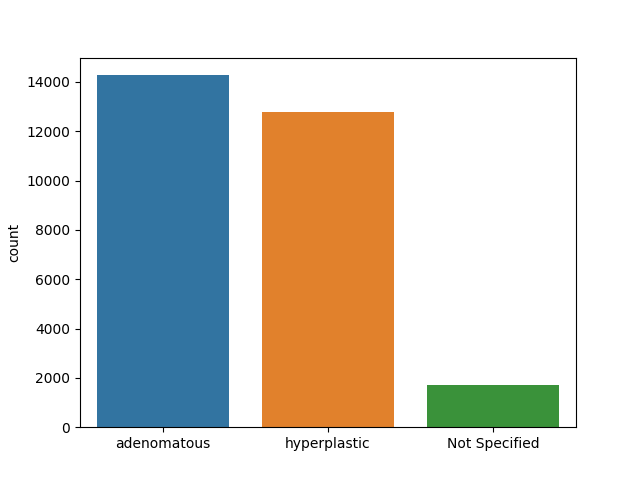

In [14]:
sns.countplot(train_y_polyp_names)

In [26]:
cln_train_X_filepaths, cln_train_X_filenames, cln_train_y_polyp_names = remove_non_labeled_polyps(
    train_X_filepaths, train_X_filenames, train_y_polyp_names)

In [27]:
len(cln_train_X_filenames)

27048

In [16]:
sns.countplot(cln_train_y_polyp_names)

C:\Users\james\miniconda3\envs\yolov4-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

In [17]:
len(cln_train_X_filepaths)

27048

In [18]:
len(cln_train_y_polyp_names)

27048

In [19]:
train_X_images = get_images(cln_train_X_filepaths, 192)

100%|████████████████████████████████████████████████████████████████████████████| 27048/27048 [06:41<00:00, 67.43it/s]


In [332]:
X_train = np.array(train_X_images)

In [333]:
X_train_small = X_train[:20]/255

In [21]:
X_train = X_train / 255

In [22]:
label_enc = LabelEncoder()
train_y = label_enc.fit_transform(cln_train_y_polyp_names)
classes = ['adenomatous', 'hyperplastic']

In [ ]:
# np.save("polyp_y_train_27048.npy", train_y)

In [ ]:
# np.save("polyp_x_train_27048.npy", X_train)

## Feature Engineer Polyp Masked Labels For Training

Use color transforms, gradients, etc. to create a polyp masked threshold binary image per polyp image. After comparing masking for 2 images. I am going to try a labeling tool instead and label 100 to 1000 images.

Here is the link I am going to try, they have built a labeling tool using matplotlib for masking images as labels that will be used for training UNet:

- [How we built an easy-to-use image segmentation tool with transfer learning](https://towardsdatascience.com/how-we-built-an-easy-to-use-image-segmentation-tool-with-transfer-learning-546efb6ae98)

Check out **GitHub Repo: [mpl-interations](https://github.com/ianhi/mpl-interactions)**

Check out **GitHub Repo: [matplotlib/ipympl](https://github.com/matplotlib/ipympl#install-the-jupyterlab-extension)**

Check out **[mpl-interactions Tutorial: Image Segmentation Label Tool](https://mpl-interactions.readthedocs.io/en/latest/examples/image-segmentation.html)**

For using custom Matplotlib Image Segmenter tool in Jupyter Notebook, you can install it with pip:

~~~bash
pip install mpl_interactions["jupyter"] # will install necessary deps for using in jupyter

# for use outside jupyter
pip install mpl_interactions

# install ipympl; they recommend installing jupyterlab >= 3
pip install ipympl

# recommended
conda install -c conda-forge jupyterlab

# need to install jupyter labextension
conda install -c conda-forge nodejs
jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-matplotlib
~~~

## Draw Masked Polyp Labels with Matplotlib's Image Segmenter

Naming convention will be polyp type followed by the original image file number.

In [23]:
%matplotlib ipympl
import matplotlib.cbook as cbook

from mpl_interactions import image_segmenter

In [263]:
polyp_img_num = 19

In [264]:
train_X_img_filename = cln_train_X_filenames[polyp_img_num]
print(train_X_img_filename)

10019.jpg


In [265]:
train_y_polyp_name = cln_train_y_polyp_names[polyp_img_num]
print(train_y_polyp_name)

hyperplastic


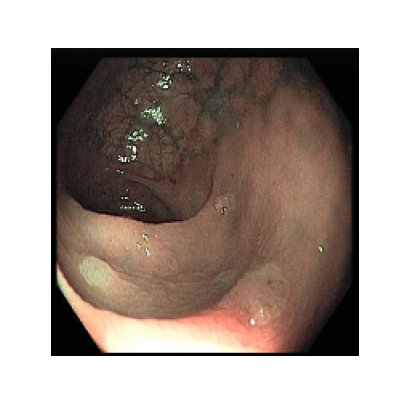

In [267]:
train_X_img_bgr = train_X_images[polyp_img_num]
train_X_img_rgb = cv2.cvtColor(train_X_img_bgr, cv2.COLOR_BGR2RGB)
segmenter = image_segmenter(train_X_img_rgb, 
                            mask_colors="yellow", 
                            mask_alpha=0.75,
                            figsize=(4, 4))
plt.axis("off")
display(segmenter)

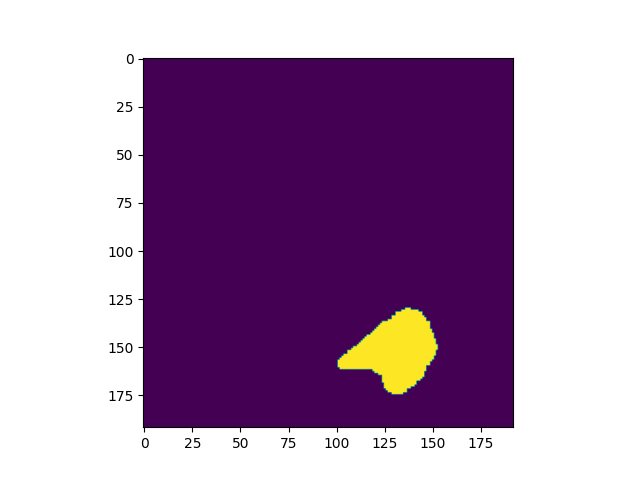

In [268]:
plt.figure()
plt.imshow(segmenter.mask)

In [269]:
# I will get a saved img 192x192 since earlier I resized img to 192x192. Factor of 32 for obj detect
plt.imsave("PolypsSet/train2019/RGBSegLabel/" + train_y_polyp_name + "_" + train_X_img_filename, 
           segmenter.mask)

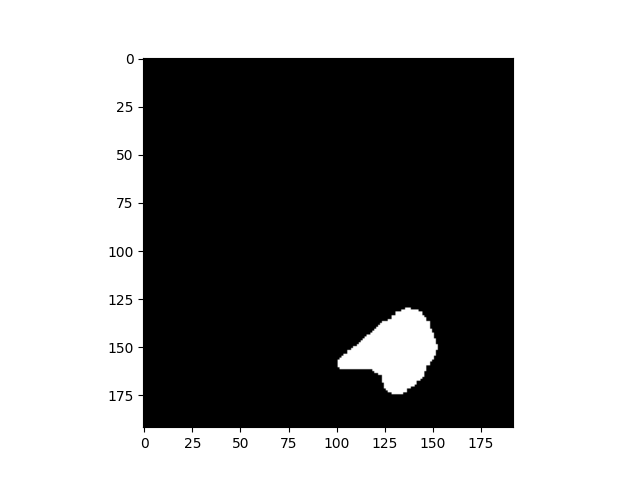

In [270]:
plt.figure()
plt.imshow(segmenter.mask, cmap = "gray")

In [271]:
plt.imsave("PolypsSet/train2019/GraySegLabel/" + train_y_polyp_name + "_" + train_X_img_filename, 
           segmenter.mask, cmap = "gray")

In [285]:
gradient_polyp = GradientThresholds()

### Apply X-Sobel Orientation Derivative Thresholding

Identify pixels where the gradient of an image falls within a specified threshold range. Check if x or y picks up polyps better.

In [778]:
orient = "x"
# Best: (10, 40) reducing x got more of polyp masked
sobel_thresh = (10, 40)
# reducing kernel size to 5 took out some noise
sobel_kernel = (5, 5)

# segmentation masked polyp image labels for each training image
seg_mask_polyp_imgs = []

In [779]:
# seg mask polyp imgs includes binary images
train_sx_binary_img = gradient_polyp.apply_sobel_thresh(
    img = train_X_images[1],
    orient = orient,
    ksize = sobel_kernel,
    thresh = sobel_thresh
)

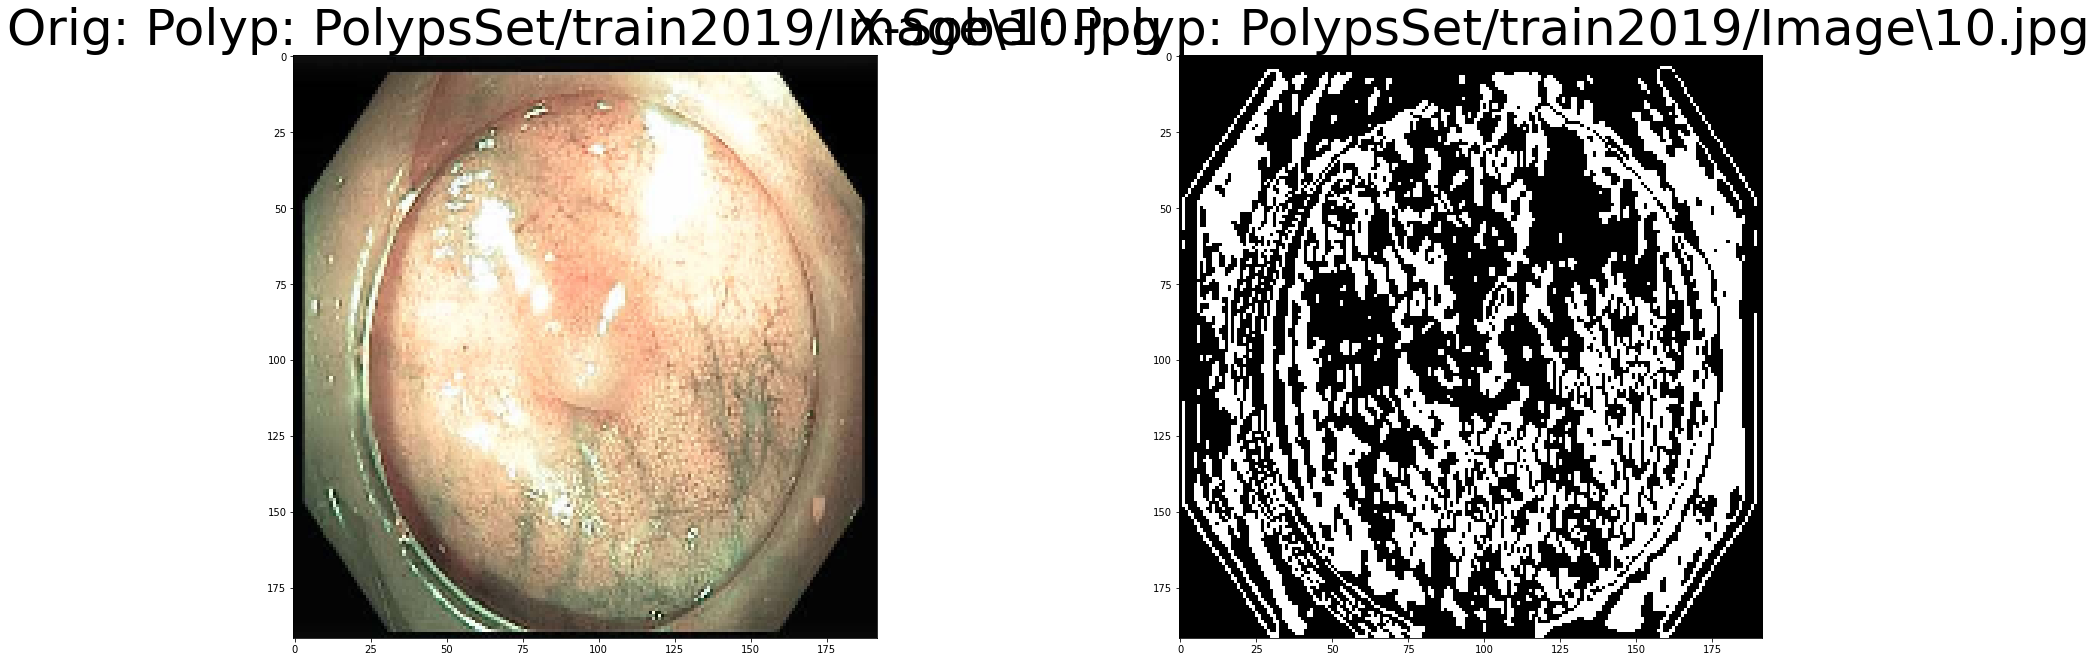

In [780]:
# visualize a figure with gradient threshold
src_title = "Orig: Polyp: " + cln_train_X_filepaths[1]
thresh_img_title = "X-Sobel: Polyp: " + cln_train_X_filepaths[1]
gradient_polyp.visualize(src_title, train_X_images[1], thresh_img_title, train_sx_binary_img)

In [ ]:
# filepath is too long
dst_img_fp = "PolypsSet/train2019/SegLabel/"
gradient_polyp.save_img(dst_img_fp, cln_train_X_filepaths[1], train_sx_binary_img)

### Apply X and Y Gradient Magnitude Thresholding

This thresholding can be done over larger regions to smooth over noisy intensity fluctuations on small scales

In [781]:
sobel_kernel = 5
mag_thresh = (10, 40) # 10, 50

In [782]:
train_grad_mag_binary_img = gradient_polyp.apply_grad_mag_thresh(
    img = train_X_images[1],
    sobel_kernel = sobel_kernel,
    mag_thresh = mag_thresh
)

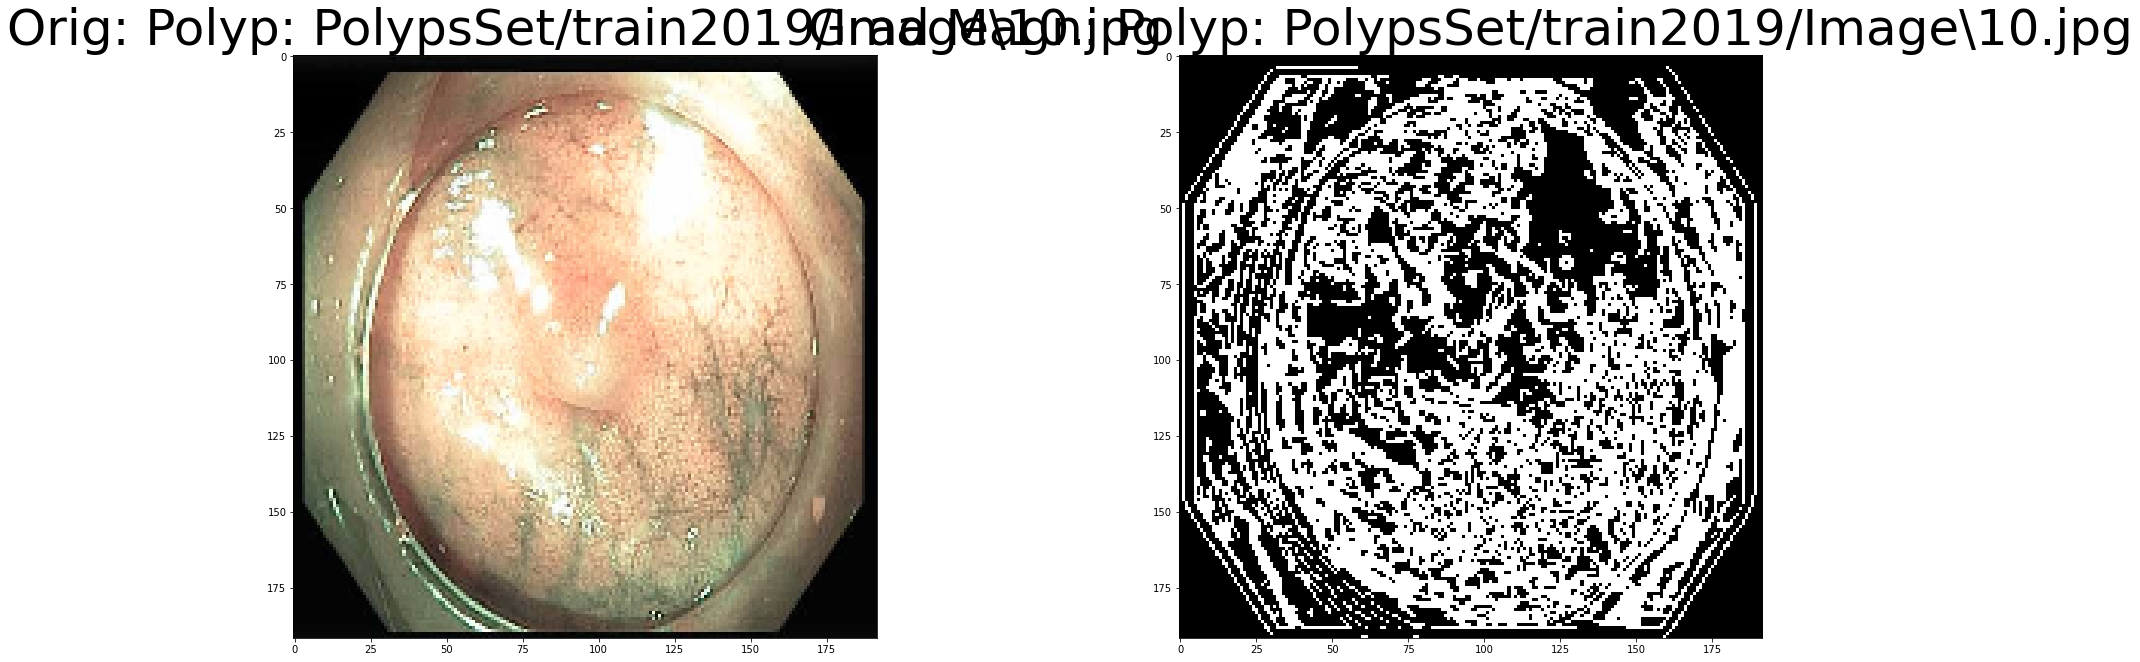

In [783]:
src_title = "Orig: Polyp: " + cln_train_X_filepaths[1]
thresh_img_title = "Grad Magn: Polyp: " + cln_train_X_filepaths[1]
gradient_polyp.visualize(src_title, train_X_images[1], thresh_img_title, train_grad_mag_binary_img)

## Apply Gradient Direction Thresholding

This thresholding is useful for picking up edges of a particular orientation.

In [784]:
sobel_kernel = 3
dir_thresh = (0.3, 1.2)

train_grad_dir_binary_img = gradient_polyp.apply_grad_dir_thresh(
    img = train_X_images[1],
    sobel_kernel = sobel_kernel,
    dir_thresh = dir_thresh
)

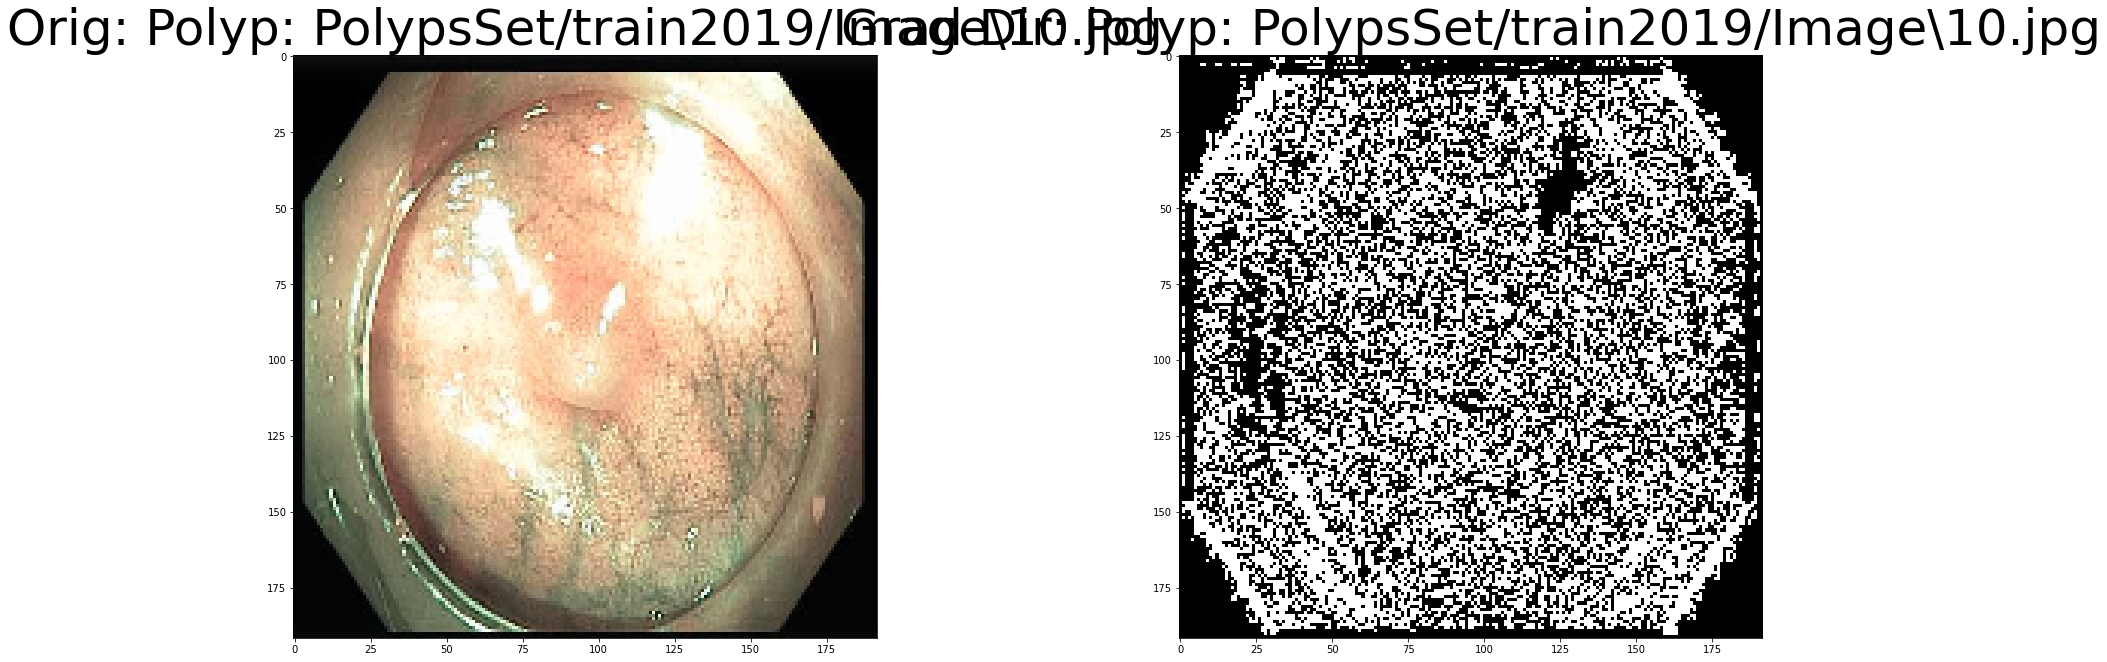

In [785]:
src_title = "Orig: Polyp: " + cln_train_X_filepaths[1]
thresh_img_title = "Grad Dir: Polyp: " + cln_train_X_filepaths[1]
gradient_polyp.visualize(src_title, train_X_images[1], thresh_img_title, train_grad_dir_binary_img)

## Apply Combined Gradient Thresholds

In [787]:
comb_grad_binary_img = gradient_polyp.apply_combined_thresh(
    combination_code = 2,
    grad_x = train_sx_binary_img,
    grad_mag = train_grad_mag_binary_img,
    grad_dir = train_grad_dir_binary_img                                          
)

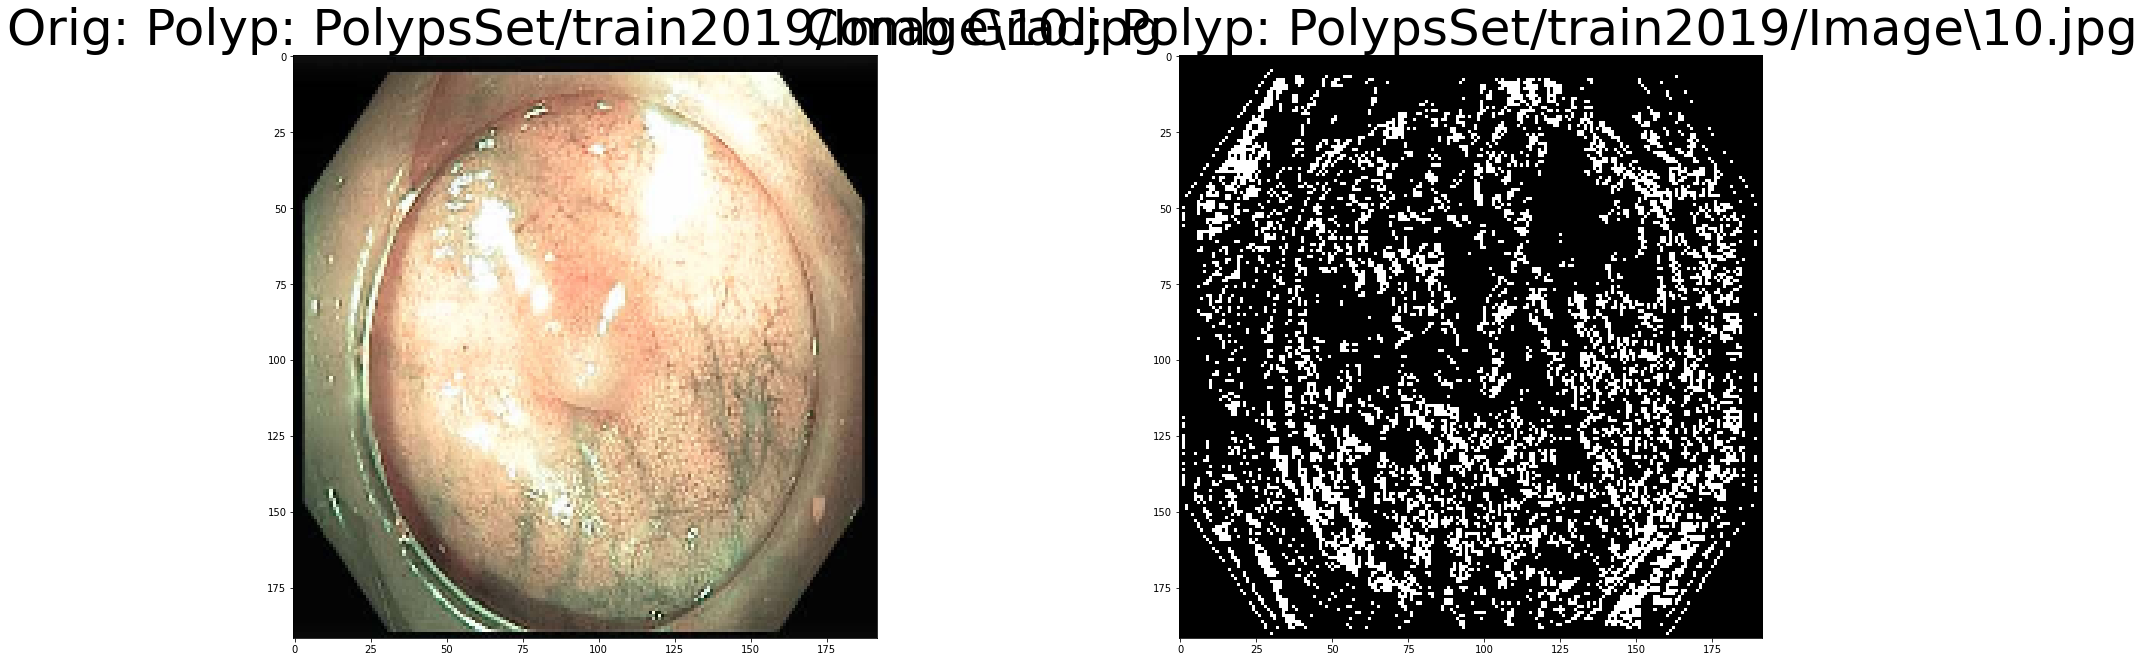

In [788]:
src_title = "Orig: Polyp: " + cln_train_X_filepaths[1]
thresh_img_title = "Comb Grad: Polyp: " + cln_train_X_filepaths[1]
gradient_polyp.visualize(src_title, train_X_images[1], thresh_img_title, comb_grad_binary_img)

## Apply RGB Thresholding

RGB Thresholding definitely works better at masking our polyps for image segmentation labels compared to gradient thresholding.

In [344]:
color_polyp = ColorThresholds()

## Apply R Thresholding

In [411]:
r_thresh = (170, 255) # (170, 255) best so far for img 1

In [481]:
red_binary_img = color_polyp.apply_r_thresh(train_X_images[1], r_thresh)

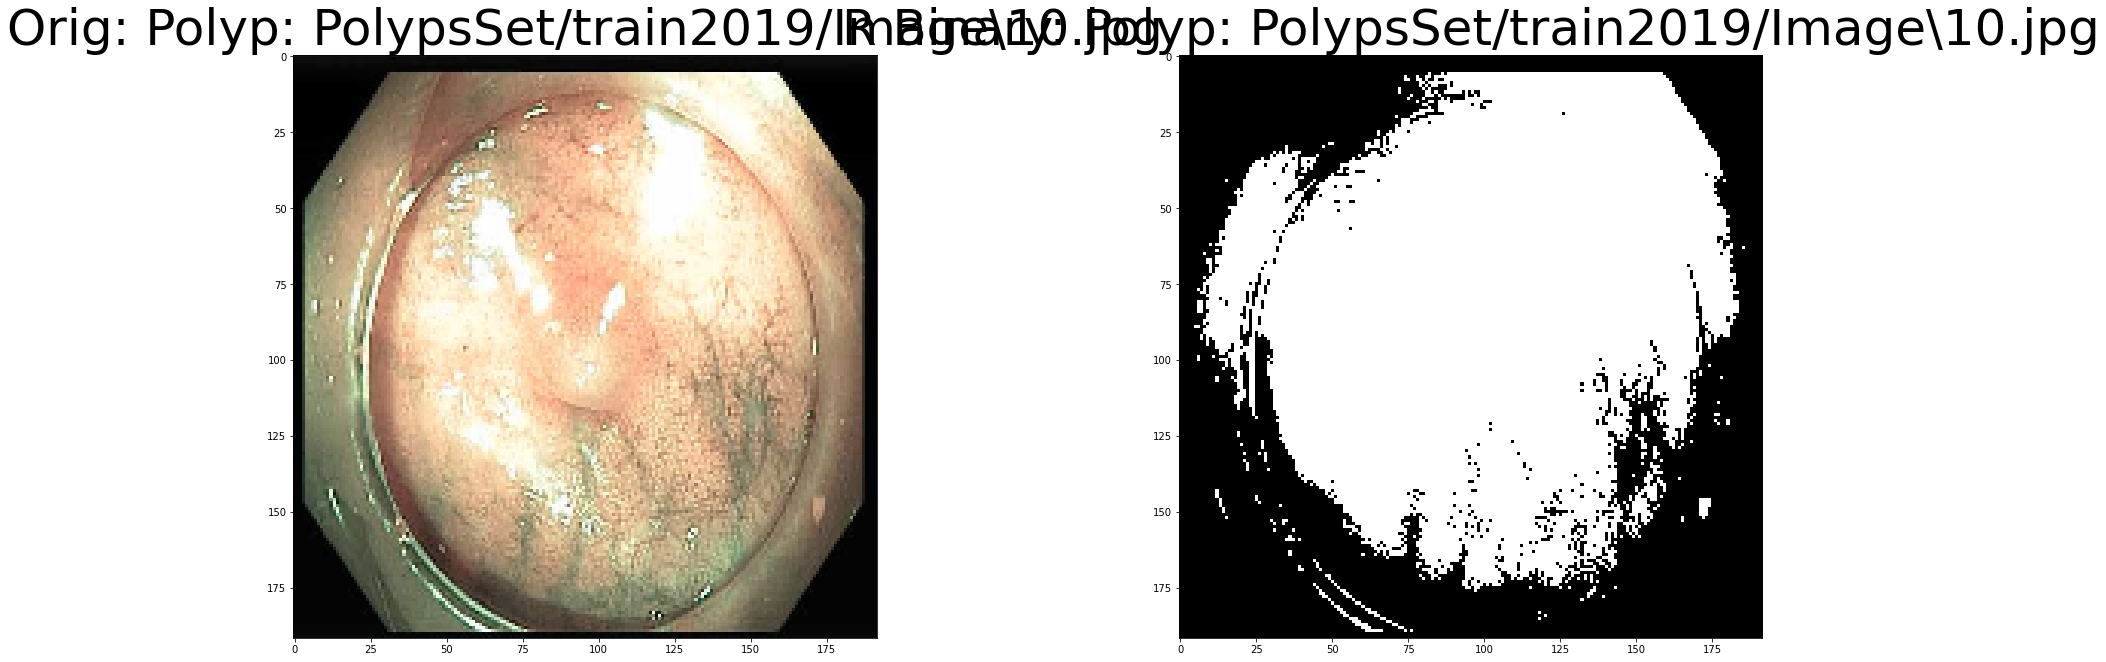

In [482]:
src_title = "Orig: Polyp: " + cln_train_X_filepaths[1]
thresh_img_title = "R Binary: Polyp: " + cln_train_X_filepaths[1]
color_polyp.visualize(src_title, train_X_images[1], thresh_img_title, red_binary_img)

## Apply G Thresholding

In [449]:
g_thresh = (130, 255) # (170, 255) best so far for img 1

In [476]:
green_binary_img = color_polyp.apply_g_thresh(train_X_images[1], g_thresh)

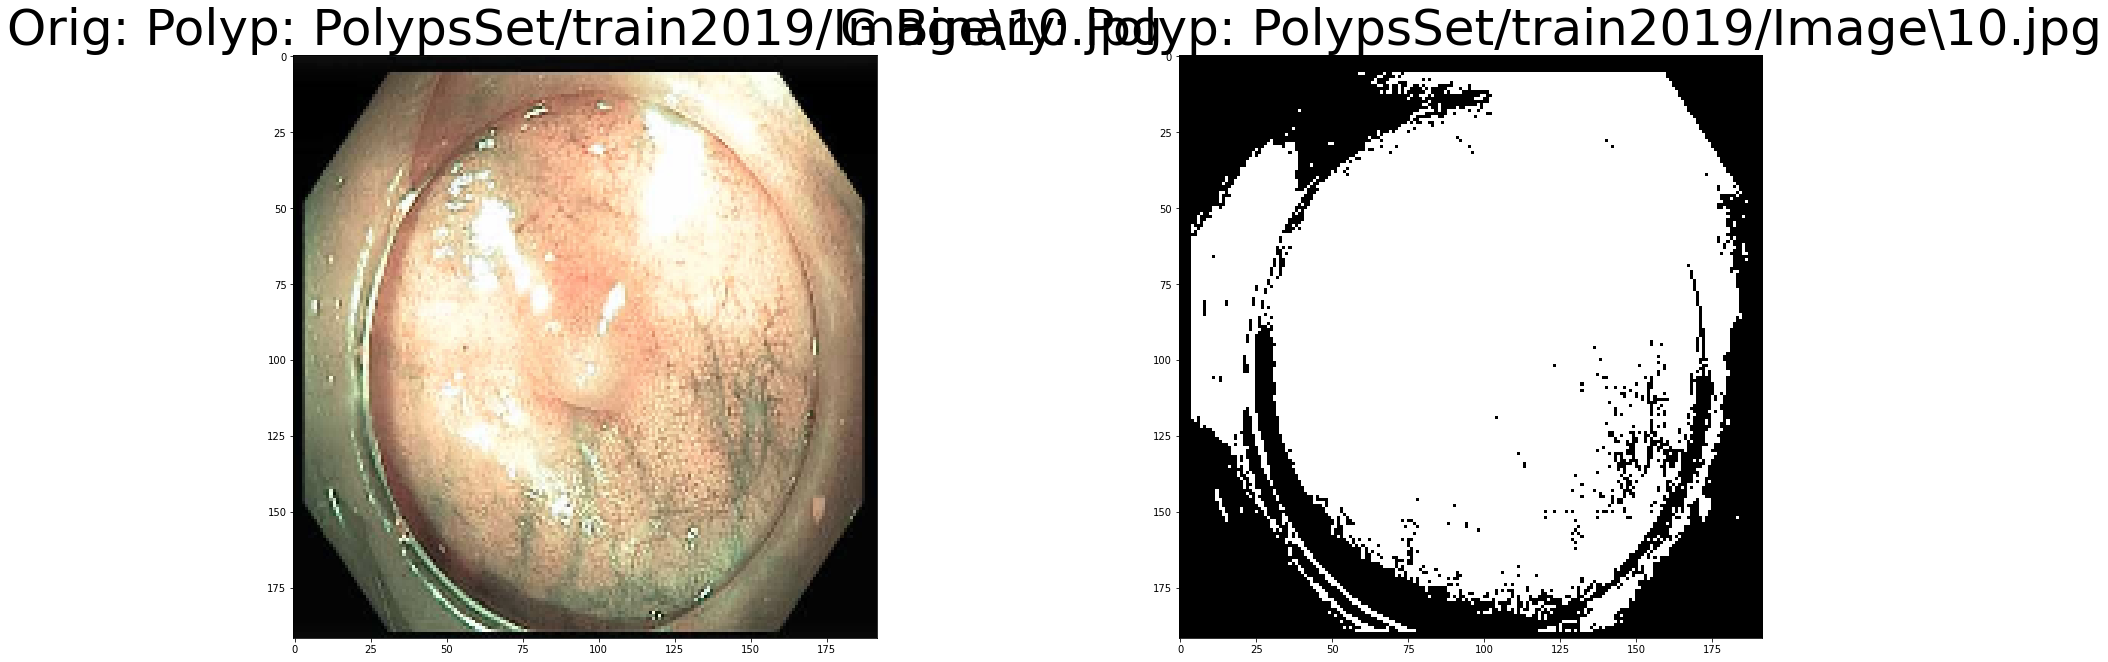

In [477]:
src_title = "Orig: Polyp: " + cln_train_X_filepaths[1]
thresh_img_title = "G Binary: Polyp: " + cln_train_X_filepaths[1]
color_polyp.visualize(src_title, train_X_images[1], thresh_img_title, green_binary_img)

## Apply B Thresholding

In [473]:
# increasing min decreased getting our masking area of interest
b_thresh = (100, 255) # (100, 255) best so far for img 1

In [479]:
blue_binary_img = color_polyp.apply_b_thresh(train_X_images[1], b_thresh)

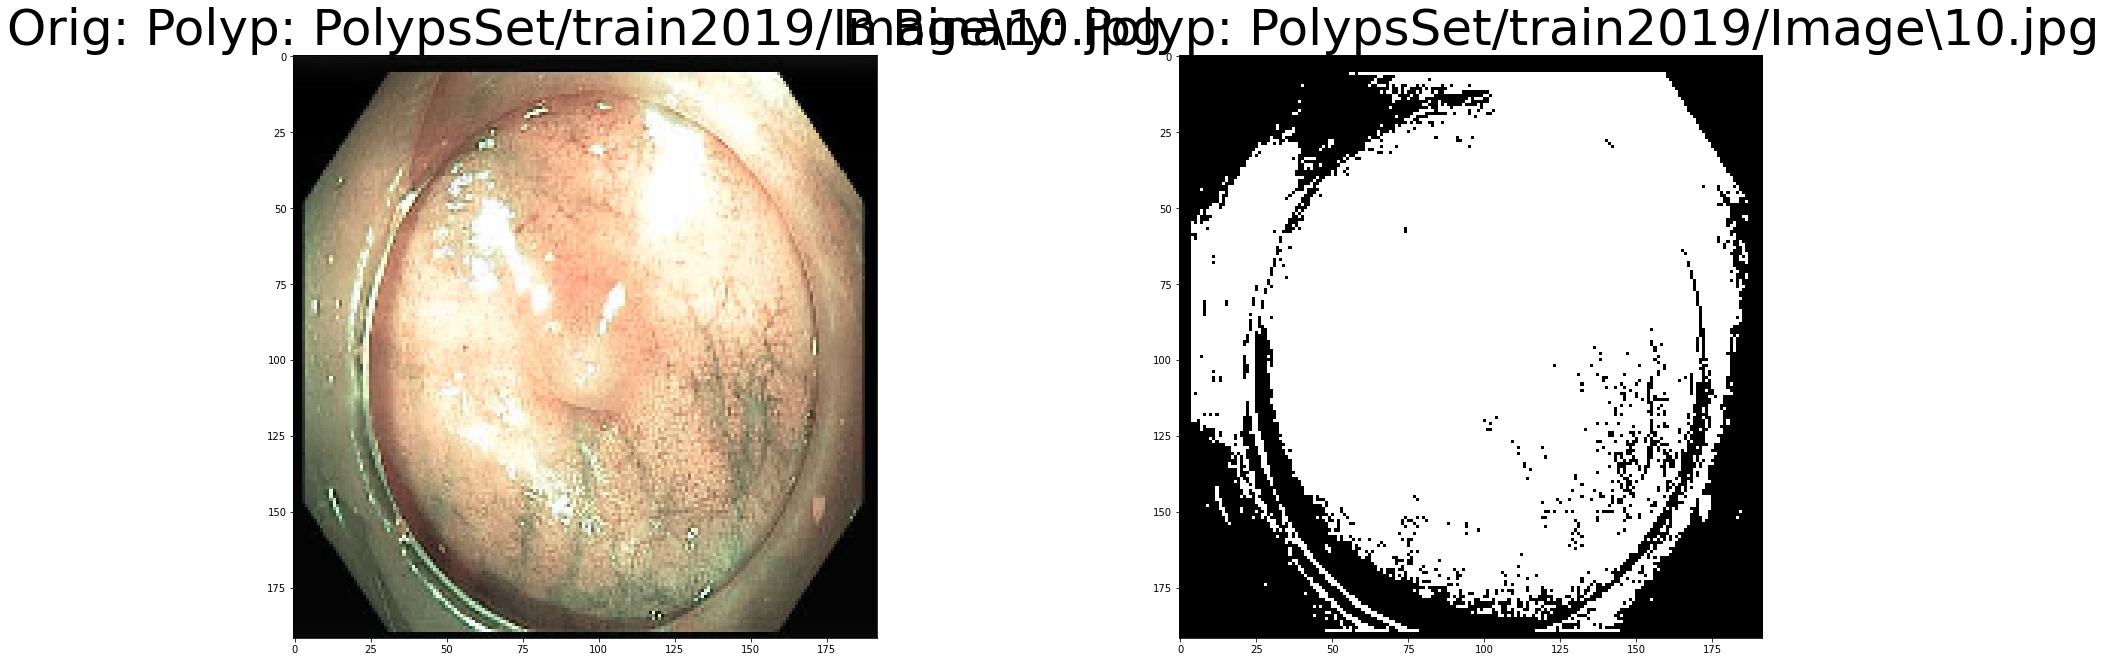

In [480]:
src_title = "Orig: Polyp: " + cln_train_X_filepaths[1]
thresh_img_title = "B Binary: Polyp: " + cln_train_X_filepaths[1]
color_polyp.visualize(src_title, train_X_images[1], thresh_img_title, blue_binary_img)

After comparing R, G, and B Thresholding, it seems R performs the best for masking our polyp of interest in image 1. But I will apply Combined RGB Thresholding since it appears G and B work better for image 2 than image 1.

In [484]:
comb_rgb_binary_img = color_polyp.apply_rgb_thresh(
    num_code = 3,
    rgb_r = red_binary_img,
    rgb_g = green_binary_img,
    rgb_b = blue_binary_img
)

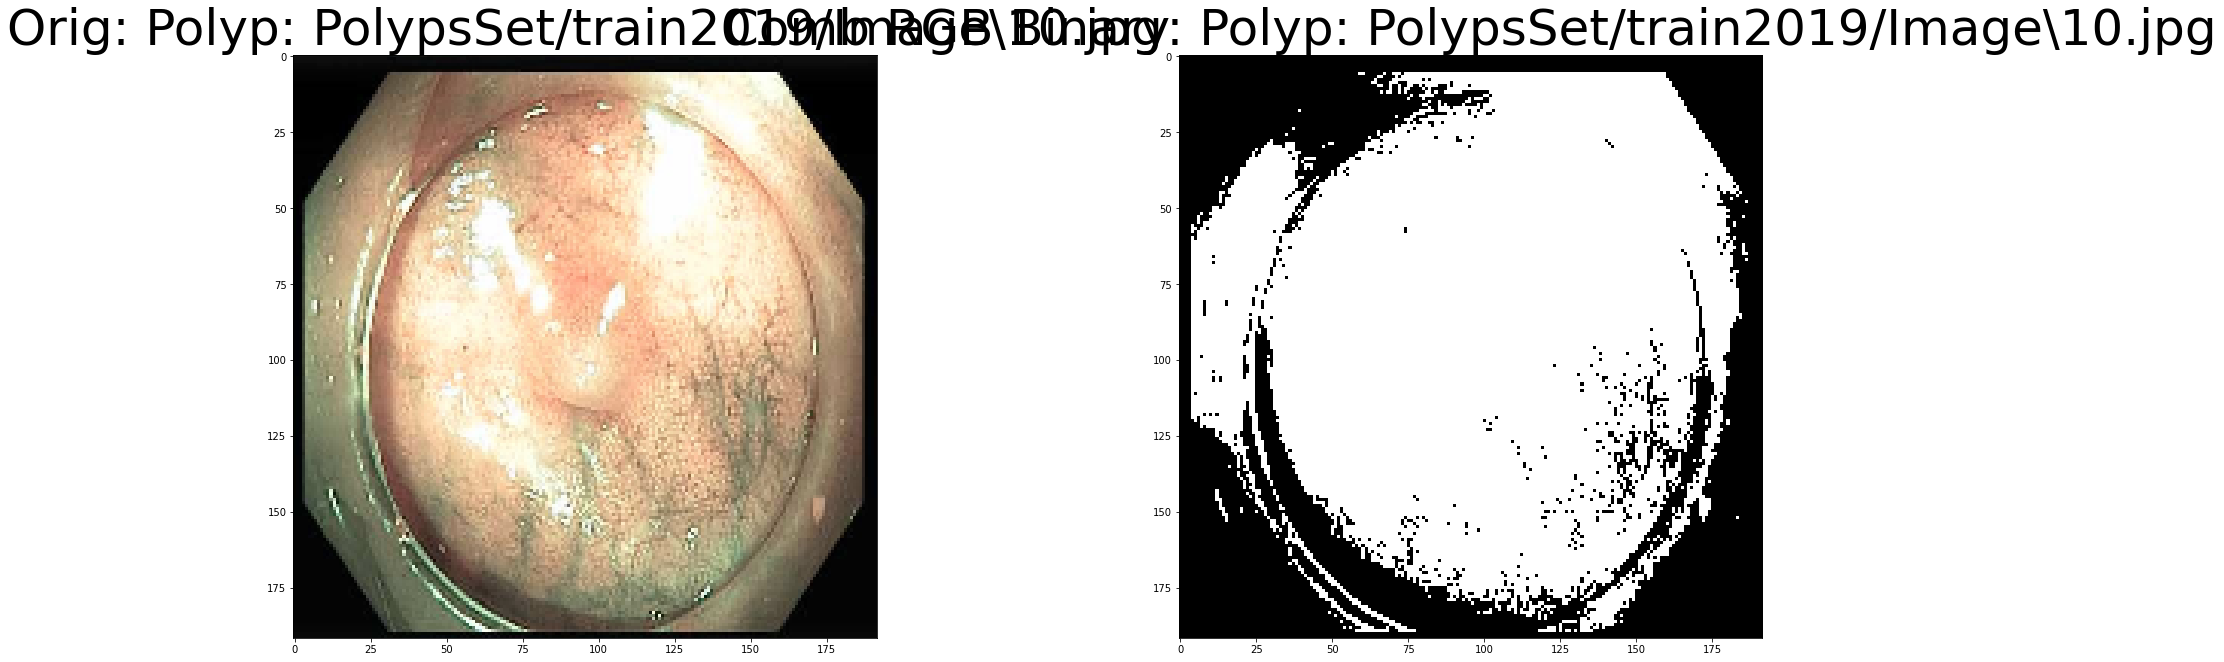

In [485]:
src_title = "Orig: Polyp: " + cln_train_X_filepaths[1]
thresh_img_title = "Comb RGB Binary: Polyp: " + cln_train_X_filepaths[1]
color_polyp.visualize(src_title, train_X_images[1], thresh_img_title, comb_rgb_binary_img)

## Apply HLS Thresholding

Hue, Lightness, Saturation

## Aply H Thresholding

In [773]:
h_thresh = (17, 55)

In [774]:
hue_binary_img = color_polyp.apply_h_thresh(train_X_images[1], h_thresh)

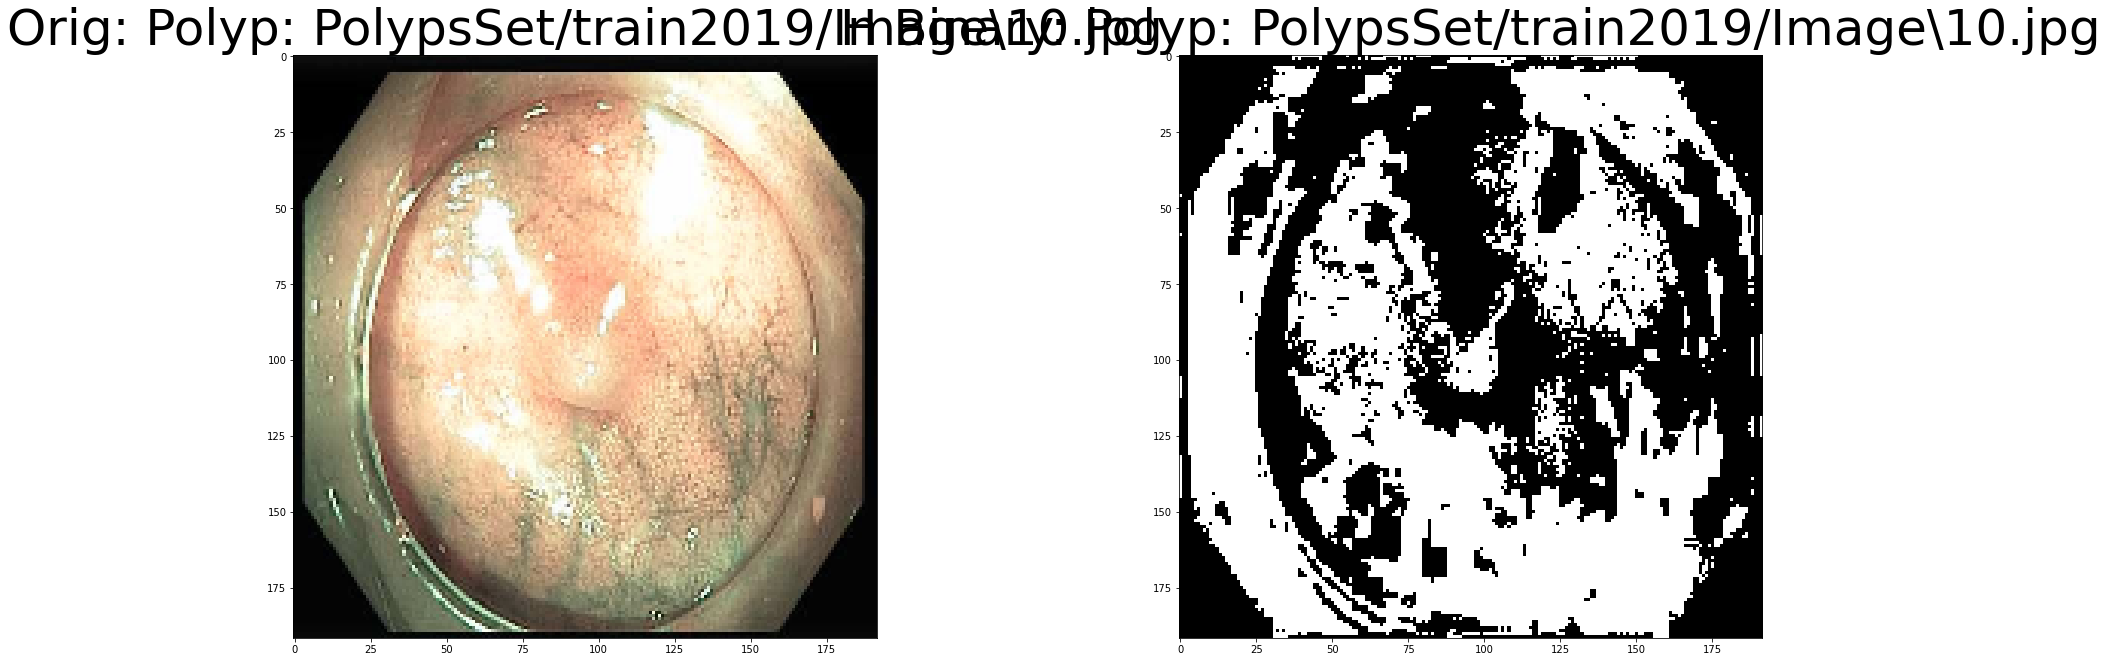

In [775]:
src_title = "Orig: Polyp: " + cln_train_X_filepaths[1]
thresh_img_title = "H Binary: Polyp: " + cln_train_X_filepaths[1]
color_polyp.visualize(src_title, train_X_images[1], thresh_img_title, hue_binary_img)

## Apply L Thresholding

In [740]:
l_thresh = (150, 255)

In [741]:
light_binary_img = color_polyp.apply_l_thresh(train_X_images[1], l_thresh)

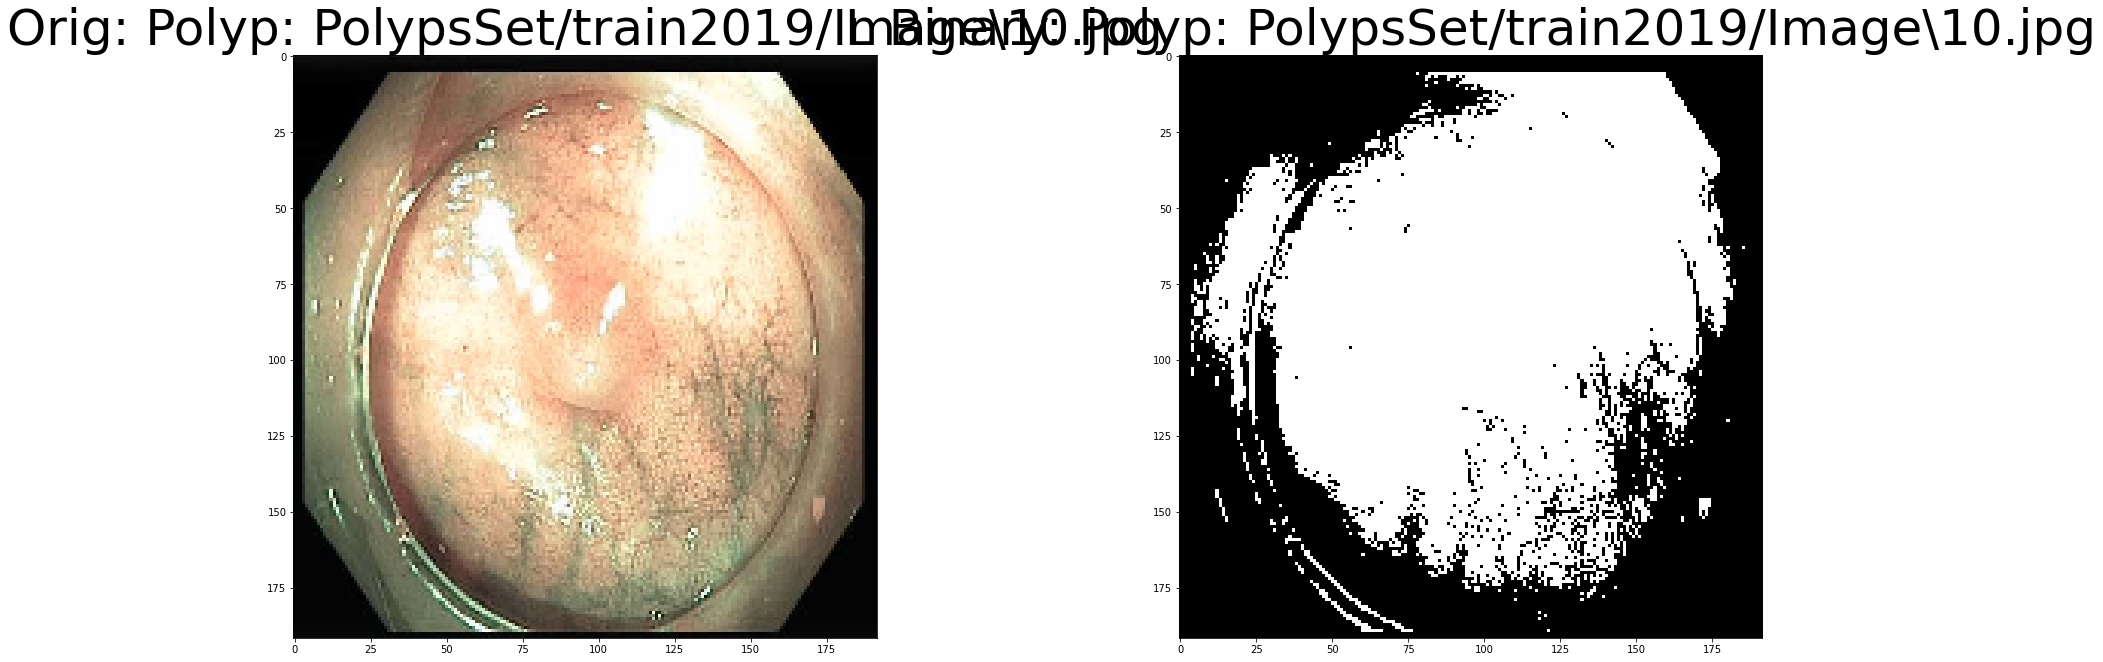

In [742]:
src_title = "Orig: Polyp: " + cln_train_X_filepaths[1]
thresh_img_title = "L Binary: Polyp: " + cln_train_X_filepaths[1]
color_polyp.visualize(src_title, train_X_images[1], thresh_img_title, light_binary_img)

## Apply S Thresholding

In [746]:
s_thresh = (70, 255)

In [747]:
sat_binary_img = color_polyp.apply_s_thresh(train_X_images[1], s_thresh)

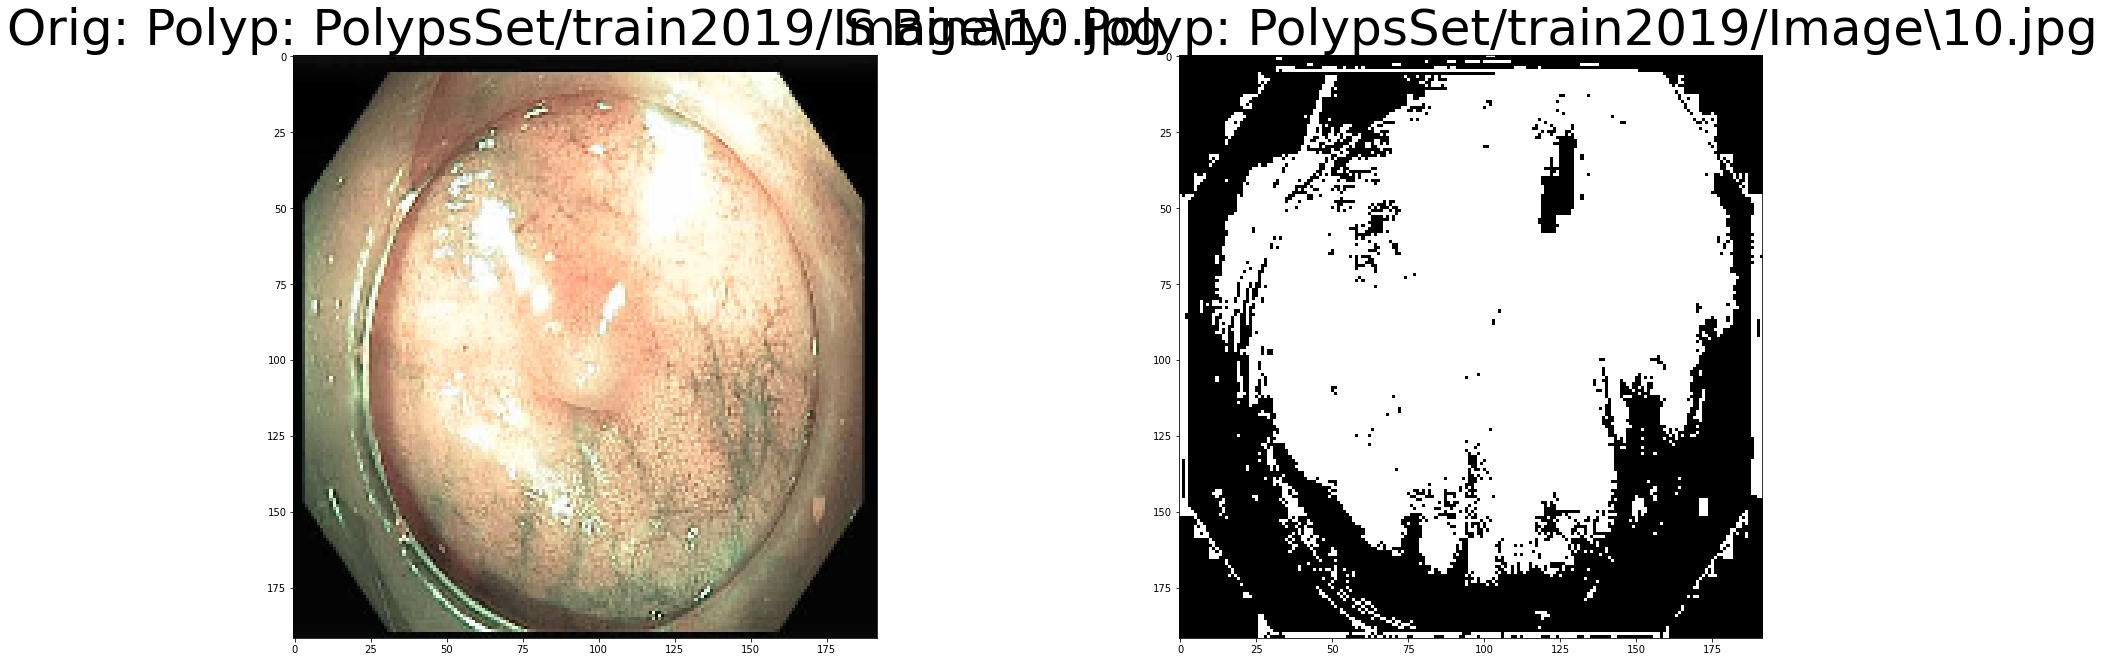

In [748]:
src_title = "Orig: Polyp: " + cln_train_X_filepaths[1]
thresh_img_title = "S Binary: Polyp: " + cln_train_X_filepaths[1]
color_polyp.visualize(src_title, train_X_images[1], thresh_img_title, sat_binary_img)

## Combine HLS Thresholding

In [776]:
comb_hls_binary_img = color_polyp.apply_hls_thresh(
    num_code = 3,
    hls_h = hue_binary_img,
    hls_l = light_binary_img,
    hls_s = sat_binary_img
)

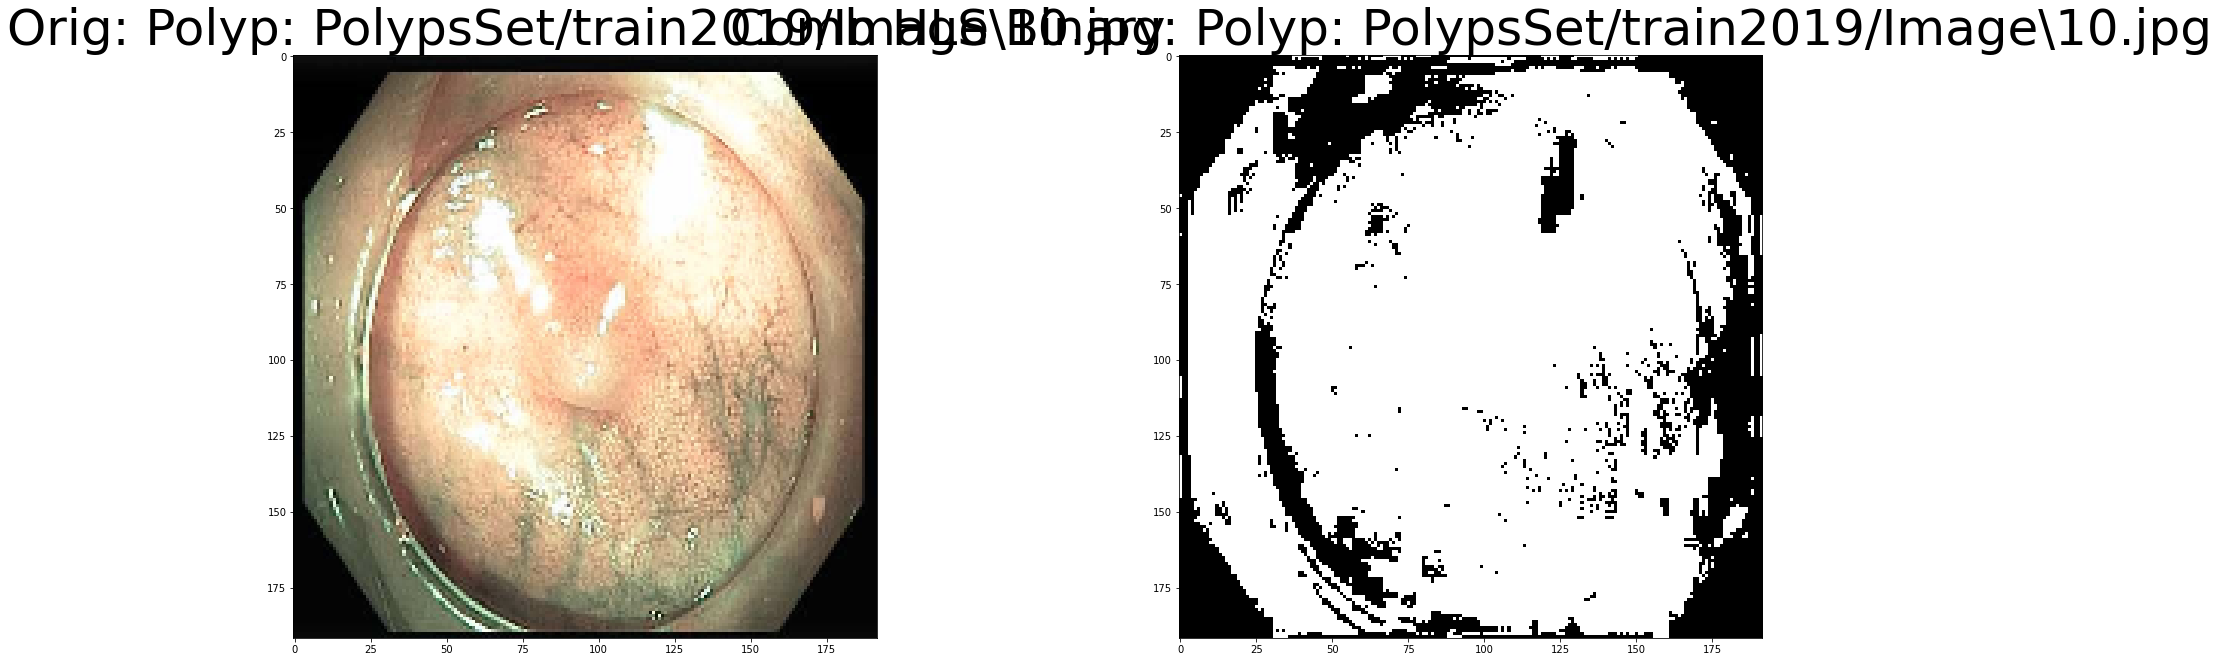

In [777]:
src_title = "Orig: Polyp: " + cln_train_X_filepaths[1]
thresh_img_title = "Comb HLS Binary: Polyp: " + cln_train_X_filepaths[1]
color_polyp.visualize(src_title, train_X_images[1], thresh_img_title, comb_hls_binary_img)

## Combine HLS & RGB Thresholding

In [789]:
hls_rgb_color_binary_img = np.dstack(
    (np.zeros_like(comb_hls_binary_img), comb_hls_binary_img, comb_rgb_binary_img)
) * 255

In [790]:
comb_hls_rgb_binary_img = np.zeros_like(comb_hls_binary_img)
comb_hls_rgb_binary_img[ (comb_hls_binary_img == 1) |
                        (comb_rgb_binary_img == 1) ] = 1

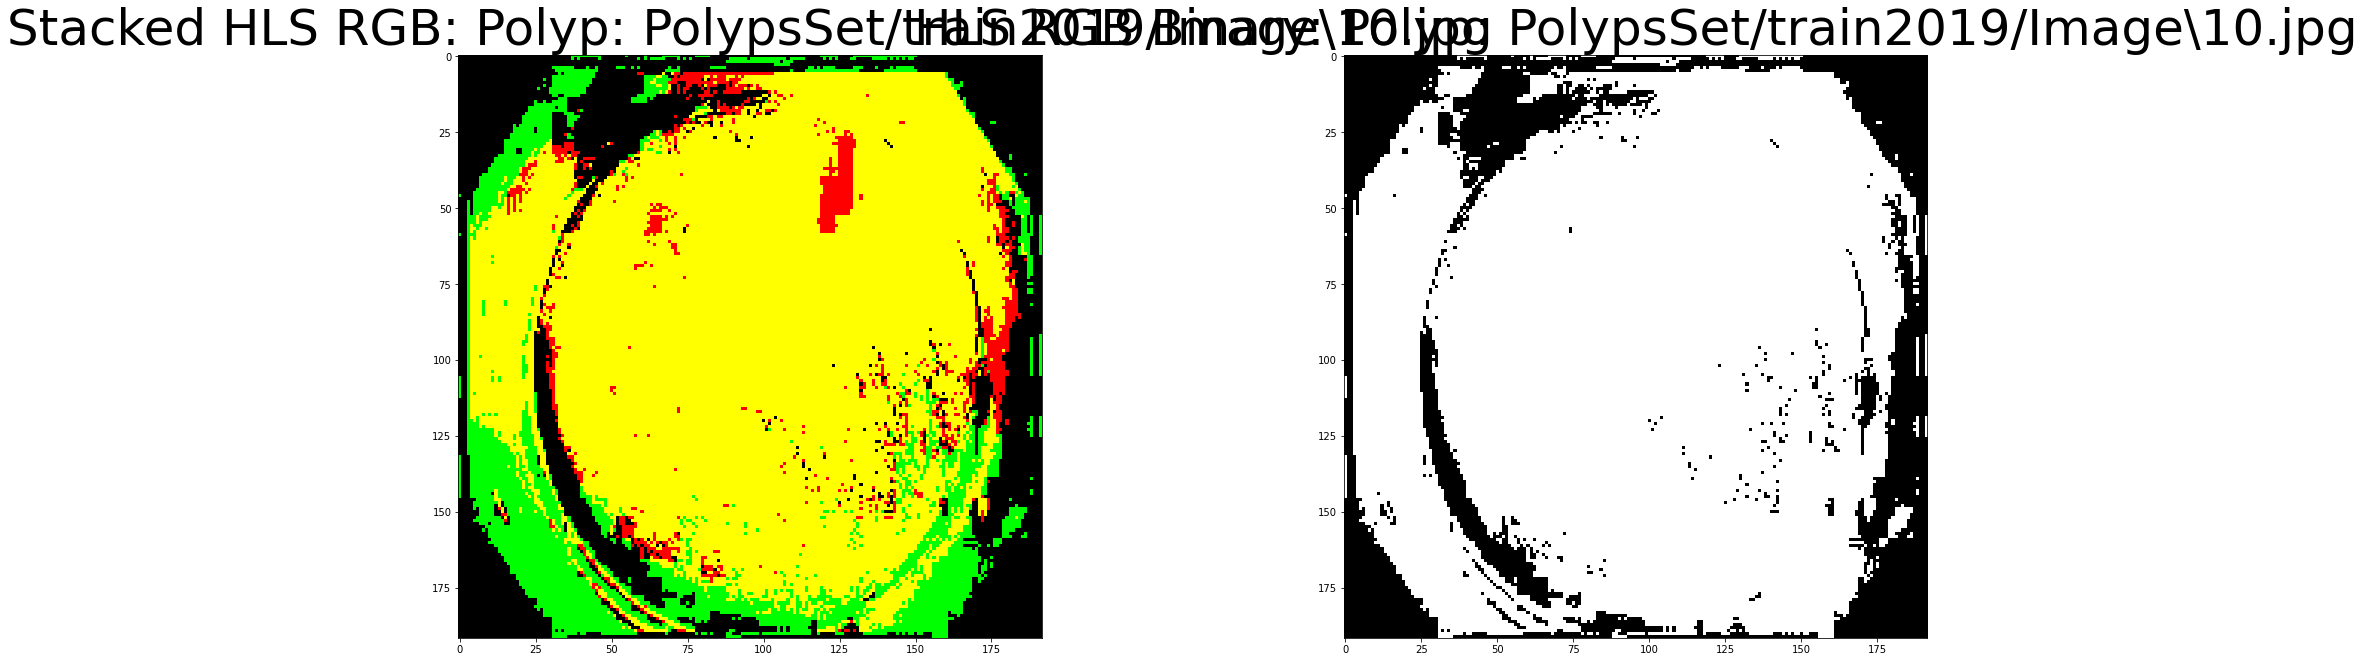

In [791]:
src_title = "Stacked HLS RGB: Polyp: " + cln_train_X_filepaths[1]
thresh_img_title = "HLS RGB Binary: Polyp: " + cln_train_X_filepaths[1]
color_polyp.visualize(src_title, hls_rgb_color_binary_img, thresh_img_title, comb_hls_rgb_binary_img)

## Loading Validation Set

In [ ]:
valid_X_basepath = "PolypsSet/val2019/Image"
valid_y_basepath = "PolypsSet/val2019/Annotation"

# Problem is that the valid set has more labels than there are images, so need to make them equal
valid_X_filepaths, valid_X_filenames, valid_y_filepaths, valid_y_filenames= get_filepaths_videonum_dirs_xy(valid_X_basepath, valid_y_basepath)

In [ ]:
valid_y_polyp_names = get_xml_label_names(valid_y_filepaths)

In [ ]:
sns.countplot(valid_y_polyp_names)

In [ ]:
cln_valid_X_filepaths, cln_valid_y_polyp_names = remove_non_labeled_polyps(
    valid_X_filepaths, valid_y_polyp_names)

In [ ]:
sns.countplot(cln_valid_y_polyp_names)

In [ ]:
valid_X_images = get_images(cln_valid_X_filepaths, 192)

In [ ]:
X_valid = np.array(valid_X_images)

In [ ]:
X_valid = X_valid / 255

In [ ]:
valid_y = label_enc.fit_transform(cln_valid_y_polyp_names)

In [ ]:
np.save("polyp_x_valid_4214.npy", X_valid)

In [ ]:
np.save("polyp_y_valid_4214.npy", valid_y)

## Loading Testing Set

In [ ]:
test_X_basepath = "PolypsSet/test2019/Image"
test_y_basepath = "PolypsSet/test2019/Annotation"

# Potential Problem is that the test set has more labels than there are images, so need to make them equal
test_X_filepaths, test_X_filenames, test_y_filepaths, test_y_filenames= get_filepaths_videonum_dirs_xy(test_X_basepath, test_y_basepath)

In [ ]:
test_y_polyp_names = get_xml_label_names(test_y_filepaths)

In [ ]:
sns.countplot(test_y_polyp_names)

In [ ]:
cln_test_X_filepaths, cln_test_y_polyp_names = remove_non_labeled_polyps(
    test_X_filepaths, test_y_polyp_names)

In [ ]:
test_X_images = get_images(cln_test_X_filepaths, 192)

In [ ]:
X_test = np.array(test_X_images)

In [ ]:
X_test = X_test / 255

In [ ]:
sns.countplot(cln_test_y_polyp_names)

In [ ]:
test_y = label_enc.fit_transform(cln_test_y_polyp_names)

In [ ]:
np.save("polyp_y_test_4719.npy", test_y)

In [ ]:
np.save("polyp_x_test_4719.npy", X_test)

## Build UNet

In [273]:
len(train_X_images[:20])

20

In [ ]:
# N = X_train.shape[-1]

In [ ]:
# y_train = np.asarray(train_y).astype('float32').reshape((-1,1))

In [ ]:
# y_train[0:3000]

In [280]:
cln_train_X_filenames[:20]

['1.jpg',
 '10.jpg',
 '100.jpg',
 '1000.jpg',
 '10000.jpg',
 '10001.jpg',
 '10002.jpg',
 '10003.jpg',
 '10005.jpg',
 '10006.jpg',
 '10007.jpg',
 '1001.jpg',
 '10010.jpg',
 '10012.jpg',
 '10014.jpg',
 '10015.jpg',
 '10016.jpg',
 '10017.jpg',
 '10018.jpg',
 '10019.jpg']

In [285]:
train_masks_basepath = "PolypsSet/train2019/GraySegLabel"
file_type = ".jpg"
train_masks_filepaths, train_masks_filenames = get_filepaths(train_masks_basepath, file_type)

In [286]:
train_masks_filepaths

['PolypsSet/train2019/GraySegLabel\\1.jpg',
 'PolypsSet/train2019/GraySegLabel\\10.jpg',
 'PolypsSet/train2019/GraySegLabel\\100.jpg',
 'PolypsSet/train2019/GraySegLabel\\1000.jpg',
 'PolypsSet/train2019/GraySegLabel\\10000.jpg',
 'PolypsSet/train2019/GraySegLabel\\10001.jpg',
 'PolypsSet/train2019/GraySegLabel\\10002.jpg',
 'PolypsSet/train2019/GraySegLabel\\10003.jpg',
 'PolypsSet/train2019/GraySegLabel\\10005.jpg',
 'PolypsSet/train2019/GraySegLabel\\10006.jpg',
 'PolypsSet/train2019/GraySegLabel\\10007.jpg',
 'PolypsSet/train2019/GraySegLabel\\1001.jpg',
 'PolypsSet/train2019/GraySegLabel\\10010.jpg',
 'PolypsSet/train2019/GraySegLabel\\10012.jpg',
 'PolypsSet/train2019/GraySegLabel\\10014.jpg',
 'PolypsSet/train2019/GraySegLabel\\10015.jpg',
 'PolypsSet/train2019/GraySegLabel\\10016.jpg',
 'PolypsSet/train2019/GraySegLabel\\10017.jpg',
 'PolypsSet/train2019/GraySegLabel\\10018.jpg',
 'PolypsSet/train2019/GraySegLabel\\10019.jpg']

In [299]:
train_mask_images = get_images(train_masks_filepaths, 192, flag = cv2.IMREAD_GRAYSCALE)

100%|████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1330.79it/s]


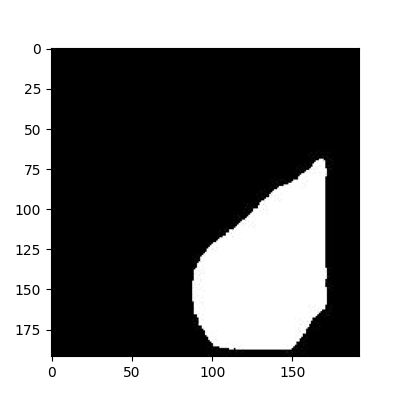

In [304]:
fig = plt.figure(figsize=(4,4))
plt.imshow(train_mask_images[0], cmap = "gray")

In [339]:
y_train_masks = np.array(train_mask_images)

In [340]:
# y_train_masks[0]

In [341]:
y_train_masks = y_train_masks/255

In [342]:
# y_train_masks[0]

In [343]:
#expand y by 1 dimension adding a 1 to the last position
y_train_masks = np.expand_dims(y_train_masks, axis=3)

In [344]:
y_train_masks.shape

(20, 192, 192, 1)

In [345]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X_train_small, y_train_masks, test_size=0.2, random_state=42
)

In [346]:
len(y_train)

16

In [347]:
len(y_test)

4

In [348]:
# https://segmentation-models.readthedocs.io/en/latest/api.html
# Can take any img size, but must be divisible by factor of 32
model = Unet(backbone_name='resnet34', input_shape=(None,None,3), 
             classes=1, activation="sigmoid", encoder_weights='imagenet')

In [355]:
# mean squared error since this is a pixel classification
# MSE is used to measure the difference between the source image and the segmented image,
# the smaller the value of RMSE, the better the segmentation performance
model.compile('Adam', loss=["binary_crossentropy"], metrics=["mse"])

In [356]:
model.fit(
    x=X_train,
    y=y_train,
    batch_size=4,
    epochs=1,
    validation_data=(X_test, y_test),
    verbose=1
)

4/4 [==============================] - 11s 2s/step - loss: 0.3879 - mse: 0.1074 - val_loss: 15.9345 - val_mse: 0.2041


## References

- [Image Segmentation: Kumaravel Subramaniam Tamilselvan and Govindasamy Murugesan](https://cdn.intechopen.com/pdfs/60741.pdf)